In [1]:
# Cell 1 - Tell python where to find the modules to import from

import sys
from pathlib import Path

#Path.cwd().parent depends on where you run this code from
#Path(__file__).resolve().parents[1] depends on where this file is located on disk
#
#project_root = .../1099-reconciliation-pipeline if notebook runs from the repo root or from notebooks/
cwd = Path.cwd()
project_root = cwd if (cwd / "src").exists() else cwd.parent # running from notebooks/  folder (cwd = current working directory) - .parent gets us to the folder above
sys.path.append(str(project_root)) #sys.path is a list of folders where python looks for modules
                                    # we add the project root to that list with .append

print("Project root: ", project_root)


Project root:  /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline


'--------------------------------  Engine B: Load & Run Analysis  --------------------------------'

In [2]:
# Cell 2 — Imports, Load & Clean inputs (real paths)

from src import load_data
from src.clean_matrix import clean_matrix
from src.clean_relius_demo import clean_relius_demo
from src.age_taxcode_analysis import run_age_taxcode_analysis
from src.age_taxcode_visualization import (
    build_age_taxcode_metrics,
    plot_corrections_over_time,
    plot_mistake_breakdown,
    build_age_taxcode_kpi_summary,
    plot_age_taxcode_kpi_summary,
    build_term_date_correction_metrics,
    plot_term_date_correction_rates,
    build_correction_reason_crosstab,
    plot_correction_reason_crosstab,
)
from src.config import RAW_DATA_DIR, REPORTS_FIGURES_DIR, USE_SAMPLE_DATA_DEFAULT

if USE_SAMPLE_DATA_DEFAULT:
    matrix_path = None
    relius_demo_path = None
else:
    matrix_path = RAW_DATA_DIR / "real_all_matrix_2025.xlsx"
    relius_demo_path = RAW_DATA_DIR / "real_demo_relius_2025.xlsx"

# Load and clean Matrix raw data
matrix_raw = load_data.load_matrix_excel(path=matrix_path)
matrix_clean = clean_matrix(matrix_raw)

# Load and clean Relius demo raw data
relius_demo_raw = load_data.load_relius_demo_excel(path=relius_demo_path)
relius_demo_clean = clean_relius_demo(relius_demo_raw)

# Run Engine B analysis
age_matches = run_age_taxcode_analysis(matrix_clean, relius_demo_clean)

print("Engine B rows:", age_matches.shape[0])
age_matches.head(5)


Engine B rows: 5


,plan_id,ssn,participant_name,state,gross_amt,fed_taxable_amt,txn_date,txn_method,tax_code_1,tax_code_2,...,attained_55_in_term_year,expected_tax_code_1,expected_tax_code_2,correction_reason,action,match_status,code_matches_expected,suggested_tax_code_1,suggested_tax_code_2,new_tax_code
0,300004PLAT,111223333,Ava Nguyen,CA,17179.62,17179.62,2024-01-17,ACH,7,G,...,False,<NA>,<NA>,<NA>,<NA>,excluded_from_age_engine_rollover_or_inherited,False,<NA>,<NA>,<NA>
1,400001ABC,222334444,Liam Patel,TX,8532.72,8532.72,2024-02-05,Wire,1,<NA>,...,False,7,<NA>,age_59_5_or_over_normal_distribution,UPDATE_1099,match_needs_correction,False,7,<NA>,7
3,300004MBD,444556666,Noah Garcia,FL,4159.71,4159.71,2024-04-12,ACH,7,<NA>,...,False,<NA>,<NA>,<NA>,<NA>,excluded_from_age_engine_rollover_or_inherited,False,<NA>,<NA>,<NA>
5,400001ABC,222334444,Liam Patel,TX,8991.28,8553.05,2099-01-01,ACH,7,<NA>,...,False,7,<NA>,<NA>,<NA>,match_no_action,True,<NA>,<NA>,<NA>
6,400001ABC,222334444,Liam Patel,TX,3000.00,9000.00,2024-02-20,Wire,ZZ,<NA>,...,False,7,<NA>,age_59_5_or_over_normal_distribution,UPDATE_1099,match_needs_correction,False,7,<NA>,7


'--------------------------------  Metrics & Plots  --------------------------------'

In [3]:
# Cell 3 — Build monthly correction metrics

metrics_df = build_age_taxcode_metrics(age_matches)
metrics_df.head(10)


,txn_month,total_txns,correction_count,correction_rate
0,2024-01-01,1,0,0.0
1,2024-02-01,2,2,1.0
2,2024-04-01,1,0,0.0
3,2099-01-01,1,0,0.0


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_b_correction_rate_by_month.png


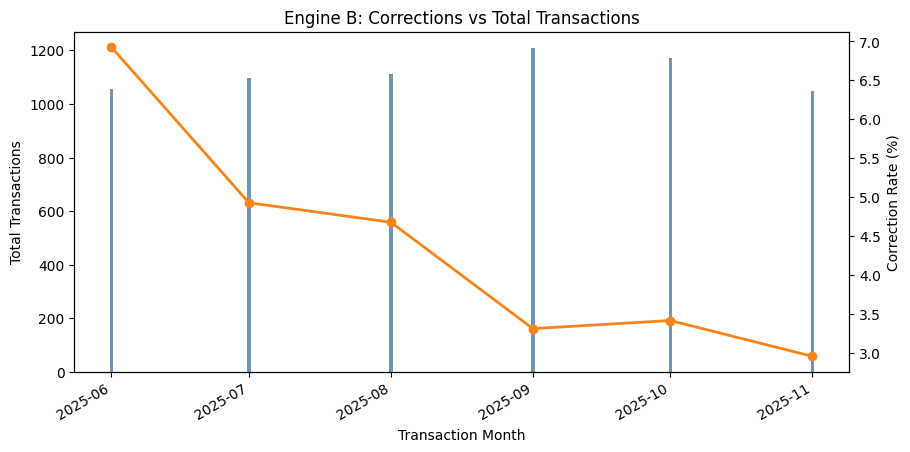

In [4]:
# Cell 4 — Plot corrections over time and save

fig1, _ = plot_corrections_over_time(metrics_df)
output_path = REPORTS_FIGURES_DIR / "engine_b_correction_rate_by_month.png"
fig1.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_b_mistake_breakdown.png


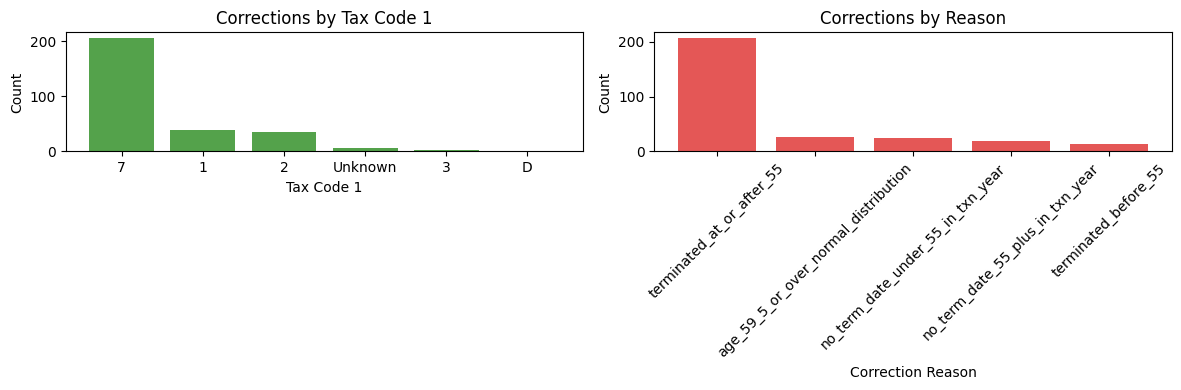

In [5]:
# Cell 5 — Plot mistake breakdown and save

fig2, _ = plot_mistake_breakdown(age_matches)
output_path = REPORTS_FIGURES_DIR / "engine_b_mistake_breakdown.png"
fig2.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [6]:
# Cell 6 — KPI summary for match status

kpi_summary = build_age_taxcode_kpi_summary(age_matches)
kpi_summary


,status_group,count,percent
0,excluded_rollover_or_inherited,1298,0.193934
1,insufficient_data,73,0.010907
2,no_action,5032,0.751830
3,needs_correction,290,0.043329


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_b_match_status_kpi.png


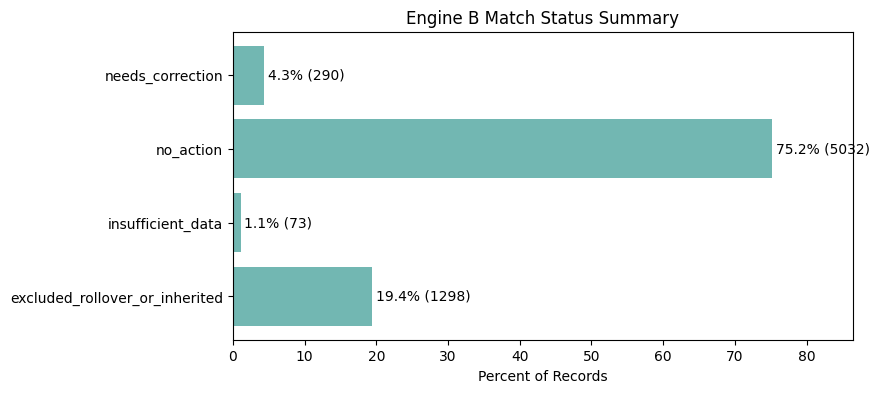

In [7]:
# Cell 7 — Plot KPI summary and save

fig3, _ = plot_age_taxcode_kpi_summary(kpi_summary)
output_path = REPORTS_FIGURES_DIR / "engine_b_match_status_kpi.png"
fig3.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [8]:
# Cell 8 — Term-date correction metrics

term_metrics = build_term_date_correction_metrics(age_matches)
term_metrics


,term_date_group,total_txns,correction_count,correction_rate
0,with_term_date,2332,235,0.100772
1,without_term_date,4361,55,0.012612


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_b_term_date_correction_rate.png


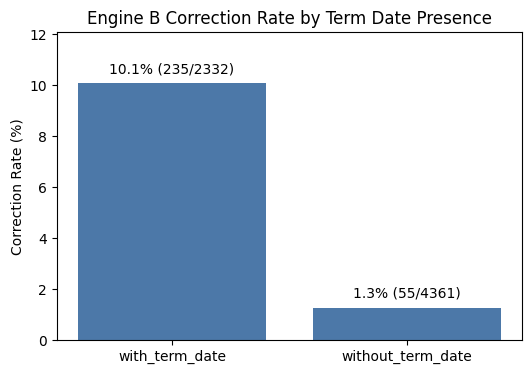

In [9]:
# Cell 9 — Plot term-date correction rates and save

fig4, _ = plot_term_date_correction_rates(term_metrics)
output_path = REPORTS_FIGURES_DIR / "engine_b_term_date_correction_rate.png"
fig4.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)


In [10]:
# Cell 10 — Correction-only cross-breakdown (tax_code_1 x correction_reason)

correction_crosstab = build_correction_reason_crosstab(age_matches)
correction_crosstab


correction_reason,age_59_5_or_over_normal_distribution,no_term_date_55_plus_in_txn_year,no_term_date_under_55_in_txn_year,terminated_at_or_after_55,terminated_before_55
tax_code_1,,,,,
1,0,13,0,26,0
2,17,0,9,0,9
3,1,0,1,0,0
7,0,6,15,181,4
D,1,0,0,0,0
Unknown,7,0,0,0,0


Saved: /Users/manuelreyes/Desktop/dev/1099_reconciliation_pipeline/reports/figures/engine_b_correction_reason_crosstab.png


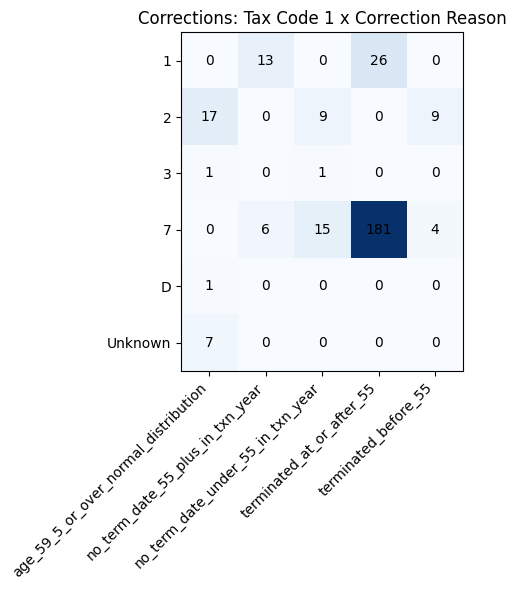

In [11]:
# Cell 11 — Plot correction cross-breakdown and save

fig5, _ = plot_correction_reason_crosstab(correction_crosstab)
output_path = REPORTS_FIGURES_DIR / "engine_b_correction_reason_crosstab.png"
fig5.savefig(output_path, dpi=150, bbox_inches="tight")
print("Saved:", output_path)
